# Setup

In [11]:
config = {
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'full_train': False,
    'all_train': False,
    'random_seed': 42,

    # random walker
    'p': 0.5,
    'q': 2,
    'num_walks': 10,
    'walk_length': 10,
    'window_size': 5,

    # EGES
    'batch_size': 326,
    'n_sampled': 10,
    'epochs': 5,
    'lr': 0.001,
    'num_feat': 9, # 1, 3, 9
    'embedding_dim': 20,
}

# Data path
ACTOR_NETWORK_DATA_PATH = '../datasets/actors_network_new.json'
TRAIN_LINK_PATH = '../datasets/eges_data_cache/train_links.csv'
VAL_LINK_PATH = '../datasets/eges_data_cache/val_links.csv'
TEST_LINK_PATH = '../datasets/eges_data_cache/test_links.csv'
SIDE_INFO_PATH = '../datasets/eges_data_cache/side_info.csv'

# Import Libraries

In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd
from itertools import chain
import pickle
import time
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import argparse
import json


# utils.py

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_embeddings(embebed_mat, side_info_mat, side_info_cols):
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(embebed_mat)
    feature_color_idx = []
    for j, feat in enumerate(side_info_cols[1:]):
        feature_color_idx.append({})
    for i in range(len(node_pos)):
        for j in range(len(feature_color_idx)):
            feature_color_idx[j].setdefault(side_info_mat[i, j], [])
            feature_color_idx[j][side_info_mat[i, j]].append(i)

    for i, feat in enumerate(feature_color_idx):
        plt.figure()
        for c, idx in feat.items():
            plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
        plt.title('{} distribution'.format(side_info_cols[i+1]))
        plt.savefig('./data_cache/{}_dist.png'.format(side_info_cols[i+1]))
        # plt.show()



def write_embedding(embedding_result, outputFileName):
    f = open(outputFileName, 'w')
    for i in range(len(embedding_result)):
        s = " ".join(str(f) for f in embedding_result[i].tolist())
        f.write(s + "\n")
    f.close()


def graph_context_batch_iter(all_pairs, batch_size, side_info, num_features):
    while True:
        start_idx = np.random.randint(0, len(all_pairs) - batch_size)
        batch_idx = np.array(range(start_idx, start_idx + batch_size))
        batch_idx = np.random.permutation(batch_idx)
        batch = np.zeros((batch_size, num_features), dtype=np.int32)
        labels = np.zeros((batch_size, 1), dtype=np.int32)
        batch[:] = side_info[all_pairs[batch_idx, 0]]
        labels[:, 0] = all_pairs[batch_idx, 1]
        yield batch, labels


def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx


def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_list(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in enumerate(vertices):
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

# alias.py

In [14]:
import numpy as np


def create_alias_table(area_ratio):
    """

    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    area_ratio = [prop * l for prop in area_ratio]
    accept, alias = [0] * l, [0] * l
    small, large = [], []

    for i, prob in enumerate(area_ratio):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio[small_idx]
        alias[small_idx] = large_idx
        area_ratio[large_idx] = area_ratio[large_idx] - \
            (1 - area_ratio[small_idx])
        if area_ratio[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias


def alias_sample(accept, alias):
    """

    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

# walker.py

In [15]:
import itertools
import math
import random

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import trange

class RandomWalker:
    def __init__(self, G, p=1, q=1):
        """
        :param G:
        :param p: Return parameter,controls the likelihood of immediately revisiting a node in the walk.
        :param q: In-out parameter,allows the search to differentiate between “inward” and “outward” nodes
        """
        self.G = G
        self.p = p
        self.q = q

    def deepwalk_walk(self, walk_length, start_node):

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk

    def node2vec_walk(self, walk_length, start_node):

        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    edge = (prev, cur)
                    next_node = cur_nbrs[alias_sample(alias_edges[edge][0],
                                                      alias_edges[edge][1])]
                    walk.append(next_node)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

        G = self.G

        nodes = list(G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))

        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(
                        walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(
                        walk_length=walk_length, start_node=v))
        return walks

    def get_alias_edge(self, t, v):
        """
        compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t.
        :param t:
        :param v:
        :return:
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0)   #保存start的邻居节点的权重
                                  for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob)/norm_const for u_prob in unnormalized_probs]  #计算从node到邻居的转移矩阵
            alias_nodes[node] = create_alias_table(normalized_probs)

        alias_edges = {}

        for edge in G.edges():
            alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


class BiasedWalker:
    def __init__(self, idx2node, temp_path):

        self.idx2node = idx2node
        self.idx = list(range(len(self.idx2node)))
        self.temp_path = temp_path
        pass

    def simulate_walks(self, num_walks, walk_length, stay_prob=0.3, workers=1, verbose=0):

        layers_adj = pd.read_pickle(self.temp_path+'layers_adj.pkl')
        layers_alias = pd.read_pickle(self.temp_path+'layers_alias.pkl')
        layers_accept = pd.read_pickle(self.temp_path+'layers_accept.pkl')
        gamma = pd.read_pickle(self.temp_path+'gamma.pkl')
        walks = []
        initialLayer = 0

        nodes = self.idx  # list(self.g.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))
        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self._exec_random_walk(layers_adj, layers_accept, layers_alias,
                                                    v, walk_length, gamma, stay_prob))
        return walks

    def _exec_random_walk(self, graphs, layers_accept, layers_alias, v, walk_length, gamma, stay_prob=0.3):
        initialLayer = 0
        layer = initialLayer

        path = []
        path.append(self.idx2node[v])

        while len(path) < walk_length:
            r = random.random()
            if(r < stay_prob):  # same layer
                v = chooseNeighbor(v, graphs, layers_alias,
                                   layers_accept, layer)
                path.append(self.idx2node[v])
            else:  # different layer
                r = random.random()
                try:
                    x = math.log(gamma[layer][v] + math.e)
                    p_moveup = (x / (x + 1))
                except:
                    print(layer, v)
                    raise ValueError()

                if(r > p_moveup):
                    if(layer > initialLayer):
                        layer = layer - 1
                else:
                    if((layer + 1) in graphs and v in graphs[layer + 1]):
                        layer = layer + 1

        return path


def chooseNeighbor(v, graphs, layers_alias, layers_accept, layer):

    v_list = graphs[layer][v]

    idx = alias_sample(layers_accept[layer][v], layers_alias[layer][v])
    v = v_list[idx]

    return v

# EGES

In [16]:
import tensorflow.compat.v1
tf.compat.v1.disable_eager_execution()
class EGES_Model:
    def __init__(self, num_nodes, num_feat, feature_lens, n_sampled=100, embedding_dim=128, lr=0.001):
        self.n_samped = n_sampled
        self.num_feat = num_feat
        self.feature_lens = feature_lens
        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes
        self.lr = lr
        self.softmax_w = tf.Variable(tf.random.truncated_normal((num_nodes, embedding_dim), stddev=0.1), name='softmax_w')
        self.softmax_b = tf.Variable(tf.zeros(num_nodes), name='softmax_b')
        self.inputs = self.input_init()
        self.embedding = self.embedding_init()
        self.alpha_embedding = tf.Variable(tf.random.uniform((num_nodes, num_feat), -1, 1))
        self.merge_emb = self.attention_merge()
        self.cost = self.make_skipgram_loss()
        # self.train_op = tf.train.AdagradOptimizer(lr).minimize(self.cost)
        self.train_op = tf.compat.v1.train.AdamOptimizer(lr).minimize(self.cost)

    def embedding_init(self):
        cat_embedding_vars = []
        for i in range(self.num_feat):
            embedding_var = tf.Variable(tf.random.uniform((self.feature_lens[i], self.embedding_dim), -1, 1), name='embedding'+str(i),
                                        trainable=True)
            cat_embedding_vars.append(embedding_var)
        return cat_embedding_vars

    def attention_merge(self):
        embed_list = []
        num_embed_list = []
        for i in range(self.num_feat):
            cat_embed = tf.nn.embedding_lookup(self.embedding[i], self.inputs[i])
            embed_list.append(cat_embed)
        stack_embed = tf.stack(embed_list, axis=-1)
        # attention merge
        alpha_embed = tf.nn.embedding_lookup(self.alpha_embedding, self.inputs[0])
        alpha_embed_expand = tf.expand_dims(alpha_embed, 1)
        alpha_i_sum = tf.reduce_sum(tf.exp(alpha_embed_expand), axis=-1)
        merge_emb = tf.reduce_sum(stack_embed * tf.exp(alpha_embed_expand), axis=-1) / alpha_i_sum
        return merge_emb

    def input_init(self):
        input_list = []
        for i in range(self.num_feat):
            input_col = tensorflow.compat.v1.placeholder(tf.int32, [None], name='inputs_'+str(i))
            input_list.append(input_col)
        input_list.append(tensorflow.compat.v1.placeholder(tf.int32, shape=[None, 1], name='label'))
        return input_list

    def make_skipgram_loss(self):
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(
            weights=self.softmax_w,
            biases=self.softmax_b,
            labels=self.inputs[-1],
            inputs=self.merge_emb,
            num_sampled=self.n_samped,
            num_classes=self.num_nodes,
            num_true=1,
            sampled_values=tf.random.uniform_candidate_sampler(
                true_classes=tf.cast(self.inputs[-1], tf.int64), 
                num_true=1, 
                num_sampled=self.n_samped, 
                unique=True, 
                range_max=self.num_nodes
            )
        ))
        return loss

# Preprocessing

In [17]:
# read json file
import pandas as pd
import json
import networkx as nx
import pandas as pd
import numpy as np
from itertools import chain
import pickle
import time
import networkx as nx
# from walker import RandomWalker
from sklearn.preprocessing import LabelEncoder
from easydict import EasyDict as edict


def get_graph_context_all_pairs(walks, window_size):
    all_pairs = []
    for k in range(len(walks)):
        for i in range(len(walks[k])):
            for j in range(i - window_size, i + window_size + 1):
                if i == j or j < 0 or j >= len(walks[k]):
                    continue
                else:
                    all_pairs.append([walks[k][i], walks[k][j]])
    return np.array(all_pairs, dtype=np.int32)

def remove_duplicates(df):
    df = df[~df[['source', 'target']].apply(frozenset, axis=1).duplicated()]
    return df

# link handling
actor_network_dict = json.load(open(ACTOR_NETWORK_DATA_PATH))

# side info handling

side_info = pd.DataFrame(actor_network_dict['nodes'])

G = nx.DiGraph()

links_df = pd.DataFrame(actor_network_dict['links'])
# drop duplicate
links_df = links_df.drop_duplicates(subset=['source', 'target'], keep='first')
# remove undirected duplicate
links_df = remove_duplicates(links_df)
# print(len(links_df))
# print(links_df)
pos_links = links_df[links_df['value'] == 1]
# print(len(pos_links))
neg_links = links_df[links_df['value'] == -1]
# print(len(neg_links))
neu_links = links_df[links_df['value'] == 0]
# print(len(neu_links))

links_set = set(map(tuple, links_df[['source', 'target']].values))
links_set.update(map(tuple, links_df[['target', 'source']].values))
# find relations not in links_df and add them to negative samples
all_links = pd.DataFrame(list(itertools.product(side_info['id'], side_info['id'])), columns=['source', 'target'])
all_links = all_links.astype(int)
# print(~all_links.isin(links_df[['source', 'target']]))

all_links = all_links[~all_links.apply(lambda row: (row['source'], row['target']) in links_set or (row['target'], row['source']) in links_set, axis=1)]
all_links = all_links.dropna()
# print(all_links)
all_links = all_links.dropna()
all_links = all_links[all_links['source'] != all_links['target']]
all_links = remove_duplicates(all_links)
all_links['value'] = 0

# print(len(pos_links), len(neg_links), len(neu_links))

# split the data
pos_links_train = pos_links.sample(n=1051, random_state=config['random_seed'])
pos_links = pos_links.drop(pos_links_train.index)
pos_links_val = pos_links.sample(n=int((len(pos_links_train) / config['train_ratio']) * config['val_ratio']), random_state=config['random_seed'])
pos_links_test = pos_links.drop(pos_links_val.index)
pos_links_test = pos_links_test.sample(n=131, random_state=config['random_seed'])

neu_links_train = neu_links.sample(n=(int(len(pos_links_train) - len(neg_links))), random_state=config['random_seed'])
neu_links = neu_links.drop(neu_links_train.index)
neu_links = pd.concat([neu_links, all_links])
neu_links_val = neu_links.sample(n=131, random_state=config['random_seed'])
neu_links_test = neu_links.drop(neu_links_val.index).sample(n=131, random_state=config['random_seed'])

print(len(pos_links_train), len(pos_links_val), len(pos_links_test))
print(len(neu_links_train), len(neu_links_val), len(neu_links_test))
print(len(neg_links))

train_links = pd.concat([pos_links_train, neg_links, neu_links_train])
val_links = pd.concat([pos_links_val, neu_links_val])
test_links = pd.concat([pos_links_test, neu_links_test])

# shuffle the data
train_links = train_links.sample(frac=1)
val_links = val_links.sample(frac=1)
test_links = test_links.sample(frac=1)


train_links.to_csv(TRAIN_LINK_PATH, index=False)
val_links.to_csv(VAL_LINK_PATH, index=False)
test_links.to_csv(TEST_LINK_PATH, index=False)

train_links = pd.read_csv(TRAIN_LINK_PATH)
val_links = pd.read_csv(VAL_LINK_PATH)
test_links = pd.read_csv(TEST_LINK_PATH)

# for link in actor_network_dict['links']:
#     if link['value'] == 1:
#         source = link['source']
#         target = link['target']
#         G.add_edge(source, target, weight=1)
#         G.add_edge(target, source, weight=1)
#         positive_samples.append((link['source'], link['target']))
#     elif link['value'] == -1:
#         negative_samples.append((link['source'], link['target']))
if config['full_train']:
    train_links = pd.concat([train_links, val_links])

if config['all_train']:
    train_links = pd.concat([train_links, val_links, test_links])

for link in train_links.iterrows():
    link = link[1]
    if link['value'] == 1:
        source = link['source']
        target = link['target']
        G.add_edge(source, target, weight=1)
        G.add_edge(target, source, weight=1)

if config['num_feat'] > 3:
    side_info.drop(['name', 'Date of Birth'], axis=1, inplace=True)
elif config['num_feat'] == 3:
    side_info = side_info[['id', 'gender', 'popularity']]
elif config['num_feat'] == 1:
    side_info = side_info[['id']]
for feat in side_info.columns:
    if feat == 'id':
        continue
    else:
        lbe = LabelEncoder()
        if side_info[feat].dtype == 'object':
            side_info.replace({feat: {0: 'Unknown'}}, inplace=True)
        side_info[feat] = lbe.fit_transform(side_info[feat])
# print(side_info.head())

side_info.to_csv(SIDE_INFO_PATH, index=False, header=False, sep='\t')
side_info_col = side_info.columns.tolist()

1051 131 131
402 131 131
649


# Random Walker

In [18]:
args = edict({
    'data_path': './data/',
    'p': config['p'],
    'q': config['q'],
    'num_walks': config['num_walks'],
    'walk_length': config['walk_length'],
    'window_size': config['window_size']
})

walker = RandomWalker(G, p=args.p, q=args.q)
print("Preprocess transition probs...")
walker.preprocess_transition_probs()

session_reproduce = walker.simulate_walks(num_walks=args.num_walks, walk_length=args.walk_length, workers=4,
                                            verbose=1)
session_reproduce = list(filter(lambda x: len(x) > 2, session_reproduce))

all_pairs = get_graph_context_all_pairs(session_reproduce, args.window_size)
np.savetxt('../datasets/eges_data_cache/all_pairs', X=all_pairs, fmt="%d", delimiter=" ")

Preprocess transition probs...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


# run EGES

In [20]:
args = edict({
    'batch_size': config['batch_size'],
    'n_sampled': config['n_sampled'],
    'epochs': config['epochs'],
    'lr': config['lr'],
    'root_path': '../datasets/eges_data_cache/',
    'num_feat': config['num_feat'],
    'embedding_dim': config['embedding_dim'],
    'outputEmbedFile': '../datasets/eges_data_cache/EGES.embed'
})

# read train_data
print('read features...')
start_time = time.time()
side_info = np.loadtxt(args.root_path + 'side_info.csv', dtype=np.int32, delimiter='\t')

all_pairs = np.loadtxt(args.root_path + 'all_pairs', dtype=np.int32, delimiter=' ')
feature_lens = []
if config['num_feat'] == 1:
    side_info_2d = np.zeros((len(side_info), 1), dtype=np.int32)
    side_info_2d[:, 0] = side_info[:]
    side_info = side_info_2d
    feature_lens.append(len(side_info_2d))
else:
    for i in range(side_info.shape[1]):
        tmp_len = len(set(side_info[:, i]))
        feature_lens.append(tmp_len)

end_time = time.time()
print('time consumed for read features: %.2f' % (end_time - start_time))

EGES = EGES_Model(len(side_info), args.num_feat, feature_lens, n_sampled=args.n_sampled, embedding_dim=args.embedding_dim,
                    lr=args.lr)

# init model
print('init...')
start_time = time.time()
init = tf.compat.v1.global_variables_initializer()
config_tf = tf.compat.v1.ConfigProto()
config_tf.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config_tf)
sess.run(init)
end_time = time.time()
print('time consumed for init: %.2f' % (end_time - start_time))

print_every_k_iterations = 100
loss = 0
iteration = 0
start = time.time()

max_iter = len(all_pairs)//args.batch_size*args.epochs
for iter in range(max_iter):
    iteration += 1
    batch_features, batch_labels = next(graph_context_batch_iter(all_pairs, args.batch_size, side_info,
                                                                    args.num_feat))
    feed_dict = {input_col: batch_features[:, i] for i, input_col in enumerate(EGES.inputs[:-1])}
    
    feed_dict[EGES.inputs[-1]] = batch_labels
    _, train_loss = sess.run([EGES.train_op, EGES.cost], feed_dict=feed_dict)

    loss += train_loss

    if iteration % print_every_k_iterations == 0:
        end = time.time()
        e = iteration*args.batch_size//len(all_pairs)
        print("Epoch {}/{}".format(e, args.epochs),
                "Iteration: {}".format(iteration),
                "Avg. Training loss: {:.4f}".format(loss / print_every_k_iterations),
                "{:.4f} sec/batch".format((end - start) / print_every_k_iterations))
        loss = 0
        start = time.time()

print('optimization finished...')
saver = tf.compat.v1.train.Saver()
saver.save(sess, "checkpoints/EGES")


feed_dict_test = {input_col: list(side_info[:, i]) for i, input_col in enumerate(EGES.inputs[:-1])}
feed_dict_test[EGES.inputs[-1]] = np.zeros((len(side_info), 1), dtype=np.int32)
embedding_result = sess.run(EGES.merge_emb, feed_dict=feed_dict_test)
print('saving embedding result...')
write_embedding(embedding_result, args.outputEmbedFile)

print('visualization...')
# plot_embeddings(embedding_result, side_info, side_info_col)

read features...
time consumed for read features: 0.06
init...
time consumed for init: 0.13
Epoch 0/5 Iteration: 100 Avg. Training loss: 2.3972 0.0037 sec/batch
Epoch 0/5 Iteration: 200 Avg. Training loss: 2.3710 0.0016 sec/batch
Epoch 0/5 Iteration: 300 Avg. Training loss: 2.3531 0.0016 sec/batch
Epoch 0/5 Iteration: 400 Avg. Training loss: 2.3191 0.0016 sec/batch
Epoch 0/5 Iteration: 500 Avg. Training loss: 2.2942 0.0016 sec/batch
Epoch 0/5 Iteration: 600 Avg. Training loss: 2.2622 0.0016 sec/batch
Epoch 0/5 Iteration: 700 Avg. Training loss: 2.2160 0.0016 sec/batch
Epoch 0/5 Iteration: 800 Avg. Training loss: 2.1729 0.0016 sec/batch
Epoch 0/5 Iteration: 900 Avg. Training loss: 2.1232 0.0016 sec/batch
Epoch 0/5 Iteration: 1000 Avg. Training loss: 2.0709 0.0016 sec/batch
Epoch 0/5 Iteration: 1100 Avg. Training loss: 2.0079 0.0016 sec/batch
Epoch 0/5 Iteration: 1200 Avg. Training loss: 1.9936 0.0016 sec/batch
Epoch 0/5 Iteration: 1300 Avg. Training loss: 1.9355 0.0017 sec/batch
Epoch 0

In [21]:
pd.DataFrame(embedding_result).to_csv('../datasets/eges_data_cache/embedding.csv', index=False, header=False)

# Xgboost

In [22]:
import xgboost as xgb
from sklearn.metrics import auc, roc_auc_score, accuracy_score

def print_performance(y_true, y_pred):
    auc_score = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print('auc: ', auc_score)
    print('acc: ', acc)

train_set = train_links.copy(deep=True)
train_y = train_set['value']
train_y.reset_index(drop=True, inplace=True)

train_y = train_y.apply(lambda x: 1 if x == 1 else 0)
train_set.drop(['value'], axis=1, inplace=True)
# concatenate the embeddings of source and target nodes
embedding_train = np.concatenate((embedding_result[train_set['source'].values], embedding_result[train_set['target'].values]), axis=1)
print(embedding_train.shape)
train_embeddings = pd.DataFrame(embedding_train,
                             columns = [source + '_emb{}'.format(i) for i in range(embedding_result.shape[1]) for source in ['source', 'target']])
if not config['full_train']:
    val_set = val_links.copy(deep=True)
    val_y = val_set['value']
    val_y.reset_index(drop=True, inplace=True)
    val_set.drop(['value'], axis=1, inplace=True)
    embedding_val = np.concatenate((embedding_result[val_set['source'].values], embedding_result[val_set['target'].values]), axis=1)
    print(embedding_val.shape)
    val_embeddings = pd.DataFrame(embedding_val,
                                columns = [source + '_emb{}'.format(i) for i in range(embedding_result.shape[1]) for source in ['source', 'target']])

test_set = test_links.copy(deep=True)
test_y = test_set['value']
test_y.reset_index(drop=True, inplace=True)
test_set.drop(['value'], axis=1, inplace=True)
embedding_test = np.concatenate((embedding_result[test_set['source'].values], embedding_result[test_set['target'].values]), axis=1)
test_embeddings = pd.DataFrame(embedding_test,
                                columns = [source + '_emb{}'.format(i) for i in range(embedding_result.shape[1]) for source in ['source', 'target']])

xgb_classifier = xgb.XGBClassifier()
# print(train_set.shape)
# print(train_y.shape)
xgb_classifier.fit(train_embeddings, train_y)

train_pred = xgb_classifier.predict(train_embeddings)
if not config['full_train']:
    val_pred = xgb_classifier.predict(val_embeddings)
test_pred = xgb_classifier.predict(test_embeddings)

print('train performance...')
print_performance(train_y, train_pred)
if not config['full_train']:
    print('val performance...')
    print_performance(val_y, val_pred)
print('test performance...')
print_performance(test_y, test_pred)

(2102, 40)
(262, 40)
train performance...
auc:  1.0
acc:  1.0
val performance...
auc:  0.5229007633587786
acc:  0.5229007633587787
test performance...
auc:  0.5114503816793893
acc:  0.5114503816793893


# Similarity Threshold

In [23]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

train_similarities = train_embeddings.apply(lambda x: cosine_similarity(x[:embedding_result.shape[1]], x[embedding_result.shape[1]:]), axis=1)
if not config['full_train']:
    val_similarities = val_embeddings.apply(lambda x: cosine_similarity(x[:embedding_result.shape[1]], x[embedding_result.shape[1]:]), axis=1)
test_similarities = test_embeddings.apply(lambda x: cosine_similarity(x[:embedding_result.shape[1]], x[embedding_result.shape[1]:]), axis=1)

train_sim_thres = train_similarities.mean() + 0.5 * train_similarities.std()
if not config['full_train']:
    val_sim_thres = val_similarities.mean() - 0 * val_similarities.std()
test_sim_thres = test_similarities.mean() - 0 * test_similarities.std()

train_pred = train_similarities.apply(lambda x: 1 if x > train_sim_thres else 0)
if not config['full_train']:
    val_pred = val_similarities.apply(lambda x: 1 if x > val_sim_thres else 0)
test_pred = test_similarities.apply(lambda x: 1 if x > test_sim_thres else 0)

print(train_y.value_counts())
print(train_pred.value_counts())
if not config['full_train']:
    print(val_y.value_counts())
    print(val_pred.value_counts())
print(test_links['value'].value_counts())
print(test_pred.value_counts())

print('train performance...')
print_performance(train_y, train_pred)
if not config['full_train']:
    print('val performance...')
    print_performance(val_y, val_pred)
print('test performance...')
print_performance(test_y, test_pred)

# print average similarity
print('train average similarity: ', train_similarities.mean())
if not config['full_train']:
    print('val average similarity: ', val_similarities.mean())
print('test average similarity: ', test_similarities.mean())

value
0    1051
1    1051
Name: count, dtype: int64
0    1248
1     854
Name: count, dtype: int64
value
1    131
0    131
Name: count, dtype: int64
1    144
0    118
Name: count, dtype: int64
value
0    131
1    131
Name: count, dtype: int64
1    133
0    129
Name: count, dtype: int64
train performance...
auc:  0.7597526165556613
acc:  0.7597526165556613
val performance...
auc:  0.5305343511450382
acc:  0.5305343511450382
test performance...
auc:  0.5572519083969466
acc:  0.5572519083969466
train average similarity:  0.578753
val average similarity:  0.37136883
test average similarity:  0.36874768


# Similarity Rankings

0.895
0.53
0.565
value
0    1051
1    1051
Name: count, dtype: int64


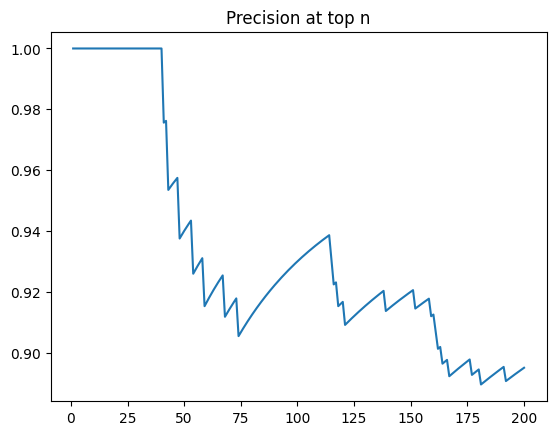

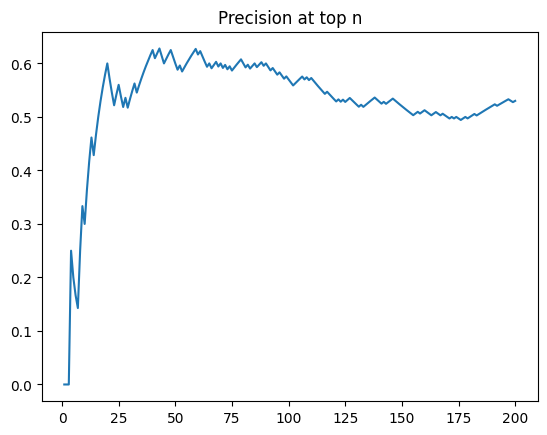

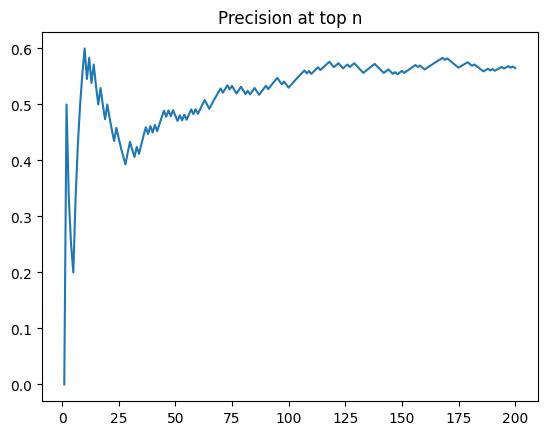

In [24]:
# get top_n similar nodes

top_n = 200

def get_top_n_similar_nodes(similarities, n):
    return similarities.nlargest(n).index

train_top_n = get_top_n_similar_nodes(train_similarities, top_n)
if not config['full_train']:
    val_top_n = get_top_n_similar_nodes(val_similarities, top_n)
test_top_n = get_top_n_similar_nodes(test_similarities, top_n)

# print(train_similarities)
# print(train_top_n)

# get precision

def get_precision(top_n, y):
    print(y[top_n].sum() / len(top_n))

train_precision = get_precision(train_top_n, train_y)
if not config['full_train']:
    val_precision = get_precision(val_top_n, val_y)
test_precision = get_precision(test_top_n, test_y)

# plot precision at different top_n
import matplotlib.pyplot as plt

def plot_precision_at_top_n(similarities, y):
    precision = []
    for i in range(1, 201):
        top_n = get_top_n_similar_nodes(similarities, i)
        precision.append(y[top_n].sum() / len(top_n))
    plt.plot(range(1, 201), precision)
    plt.title('Precision at top n')
    plt.show()

print(train_y.value_counts())
plot_precision_at_top_n(train_similarities, train_y)
if not config['full_train']:
    plot_precision_at_top_n(val_similarities, val_y)
plot_precision_at_top_n(test_similarities, test_y)

# XGBoost with no Graph

In [26]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


train_links = pd.read_csv(TRAIN_LINK_PATH)
val_links = pd.read_csv(VAL_LINK_PATH)
test_links = pd.read_csv(TEST_LINK_PATH)

# Assuming 'actor_network_dict' and 'train_links', 'val_links', 'test_links' are already defined

side_info = pd.DataFrame(actor_network_dict['nodes'])

# Convert 'Date of Birth' to datetime and extract features
side_info['Date of Birth'] = pd.to_datetime(side_info['Date of Birth'], errors='coerce')
side_info['Birth Year'] = side_info['Date of Birth'].dt.year
side_info['Birth Month'] = side_info['Date of Birth'].dt.month
side_info['Birth Day'] = side_info['Date of Birth'].dt.day
side_info.drop(columns=['Date of Birth'], inplace=True)

# Label encode categorical columns
label_encoders = {}
for column in ['name', 'popularity', 'Birth City', 'Birth Country', 'Ethnicity']:
    le = LabelEncoder()
    side_info[column] = le.fit_transform(side_info[column].astype(str))
    label_encoders[column] = le

train_y = train_links['value']
# print(len(train_y))
train_y = train_y.apply(lambda x: 1 if x == 1 else 0)
val_y = val_links['value']
val_y = val_y.apply(lambda x: 1 if x == 1 else 0)
test_y = test_links['value']
test_y = test_y.apply(lambda x: 1 if x == 1 else 0)

train_side_info_source = side_info.loc[train_links['source']]
train_side_info_target = side_info.loc[train_links['target']]
train_side_info_target.columns = [col + '_target' for col in train_side_info_target.columns]
train_side_info_source.reset_index(drop=True, inplace=True)
train_side_info_target.reset_index(drop=True, inplace=True)
train_side_info = pd.concat([train_side_info_source, train_side_info_target], axis=1)

val_side_info_source = side_info.loc[val_links['source']]
val_side_info_target = side_info.loc[val_links['target']]
val_side_info_target.columns = [col + '_target' for col in val_side_info_target.columns]
val_side_info_source.reset_index(drop=True, inplace=True)
val_side_info_target.reset_index(drop=True, inplace=True)
val_side_info = pd.concat([val_side_info_source, val_side_info_target], axis=1)
val_side_info.reset_index(drop=True, inplace=True)

test_side_info_source = side_info.loc[test_links['source']]
test_side_info_target = side_info.loc[test_links['target']]
test_side_info_target.columns = [col + '_target' for col in test_side_info_target.columns]
test_side_info_source.reset_index(drop=True, inplace=True)
test_side_info_target.reset_index(drop=True, inplace=True)
test_side_info = pd.concat([test_side_info_source, test_side_info_target], axis=1)
test_side_info.reset_index(drop=True, inplace=True)


# Drop 'id' column as it's not needed for training
train_side_info.drop(['id'], axis=1, inplace=True)
val_side_info.drop(['id'], axis=1, inplace=True)
test_side_info.drop(['id'], axis=1, inplace=True)

# Define and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(enable_categorical=True)
print(train_y)
print(train_side_info)
xgb_classifier.fit(train_side_info, train_y)

# Predictions
train_pred = xgb_classifier.predict(train_side_info)
val_pred = xgb_classifier.predict(val_side_info)
test_pred = xgb_classifier.predict(test_side_info)

# Performance evaluation
print('train performance...')
print_performance(train_y, train_pred)
print('val performance...')
print_performance(val_y, val_pred)
print('test performance...')
print_performance(test_y, test_pred)

0       0
1       0
2       0
3       0
4       0
       ..
2097    1
2098    0
2099    1
2100    0
2101    0
Name: value, Length: 2102, dtype: int64
      name  gender  popularity  Birth City  Birth Country  Height (Inches)  \
0     1631     1.0         827         120             38             62.0   
1      191     2.0         901           0              0              0.0   
2      270     1.0         995         233             39             67.0   
3     1646     2.0        1622           0              0              0.0   
4     1263     2.0        1375          53             39             61.0   
...    ...     ...         ...         ...            ...              ...   
2097  1580     2.0        1809           0              0              0.0   
2098  1520     1.0        1310           0              0              0.0   
2099   339     2.0         937          12             39             61.0   
2100  1638     2.0         705         107             39             

/var/folders/s9/mtpbbk4x5js8w0v95kwmby8m0000gn/T/ipykernel_74695/4196092060.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  side_info['Date of Birth'] = pd.to_datetime(side_info['Date of Birth'], errors='coerce')
